# In this notebook we will attempt to run Bayesian Regression on the full NBA dataset for 2018/19 season using priors from player contracts.

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

data = pd.read_csv("../data/shifts_data_final_2018_19.csv")
data.drop(data.columns[0], axis = 1, inplace = True)
data.head()

,point_diff_per_100,home_team,away_team,0,1,2,3,4,5,6,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,Celtics,Nuggets,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,Celtics,Nuggets,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,Celtics,Nuggets,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
priors_df = pd.read_csv("../data/priors_team_contract_formatted.csv")
priors_df.drop(priors_df.columns[0], axis = 1, inplace = True)
priors_df.head()


,name,mu,sd
0,Marcus Morris,0.000000,5
1,Jayson Tatum,-0.718928,5
2,Jaylen Brown,-1.127152,5
3,Terry Rozier,-1.692371,5
4,Robin Lopez,3.284328,5


In [3]:
prior_means = np.array(priors_df.mu)
prior_sd = np.array(priors_df.sd)

In [4]:
# store home and away teams for potential use later when we incorporate team ratings
home_teams = data['home_team']
away_teams = data['away_team']
# now drop these columns from the main training dataframe
data.drop(['home_team', 'away_team'], axis = 1, inplace = True)
data.head()

,point_diff_per_100,0,1,2,3,4,5,6,7,8,...,519,520,521,522,523,524,525,526,527,528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# need to rename columns now since numbers confuse pymc3
new_cols = []
for i in range(np.shape(data)[1]):
    if i == 0:
        new_cols.append("point_diff")
    else:
        new_cols.append("p" + str(i-1))

x_df = data.iloc[:10000,]
x_df.columns = new_cols
x_df

,point_diff,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p519,p520,p521,p522,p523,p524,p525,p526,p527,p528
0,-36.458333,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,39.062500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-72.337963,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-36.168981,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,38.296569,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-17.536476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,23.460961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,-236.742424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Bayesian Regression

After fixing our measurement of +/- to be on the scale of per 100 possessions instead of per possession, the Bayesian Regression model now seems to give quite reasonable estimates. Also - we fit the model below using the `shape` parameter rather than a list comprehension and it seems to work fine.

Note - Steph Curry is index 317 and Lebron James is index 225, so for sanity checks we can check these players' coefficients compared to a random player. 



In [6]:
x = np.array(x_df.iloc[:,1:])
y = np.array(x_df.iloc[:,0])

x_shape = np.shape(x)[1]

with pm.Model() as model:
    # priors
    sigma = pm.HalfCauchy("sigma", beta=10) # arbitrarily defined
    intercept = pm.Normal("Intercept", 0, sigma=20) # arbitrarily defined
    x_prior_means = prior_means # defined above
    x_prior_sigmas = prior_sd # defined above
#     x_prior_means = np.zeros(x_shape) # just testing with mean zero to compare to ridge
    x_coeff = pm.Normal("x", mu = x_prior_means, sigma=x_prior_sigmas, shape = x_shape) # original method - no list comprehension
#     x_coeff = [pm.Normal("x" + str(i), mu = x_prior_means[i], sigma=x_prior_sigmas[i]) for i in range(529)] # new method - list comprehension
    
    likelihood = pm.Normal("y", mu=intercept + x_coeff.dot(x.T), sigma=sigma, observed=y) # original method - no list comprehension
#     likelihood = pm.Normal("y", mu = intercept + sum([x_coeff[i] * x[:,i] for i in range(529)]), sigma = sigma, observed = y) # new method - list comprehension and sum. This throws an exception 
#     likelihood = pm.Normal("y", mu = intercept + np.array(x_coeff).dot(x.T), sigma = sigma, observed = y) # another new method - dot product after using list comp for x_coeff. This one doesn't run
#     except:
#         print(i)
#         print(x_coeff[i])
    trace = pm.sample(1000, tune = 1000, cores = 1)
    
    
    

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [x, Intercept, sigma]


/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 325 seconds.


In [43]:
# This was using the list comp method:
with model:
    print((intercept + sum([x_coeff[i] * x[:,i] for i in range(529)])))

Elemwise{add,no_inplace}.0


In [50]:
# This is using the shape method:
with model:
    print(x_coeff)

x ~ Normal


In [7]:
results_df = az.summary(trace)

/Users/reedpeterson/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [64]:
np.std(results_df['mean'])
np.std(prior_means)

2.619570495497698

## Assessing Results of Bayesian Regression in Context

**Before adjusting for teams, uncentered contract priors**, the highest coefficients (in order) are:
* Steph Curry
* James Harden
* Al Horford (he was a solid player on a good Celtics team in 2018/19 looking at box score statistics)
    * Horford also had a very high salary 28,928,710 this season which probably is contributing to this high coefficient
* LeBron James
* Giannis
* Paul Millsap
* Mike Conley
* Russel Westbrook
* Marc Gasol
* Chris Paul

This seems reasonable. The Bayesian regression seems to be learning the right things now. The coefficients are not centered still, since we have not yet centered contracts properly, but the relative ordering of coefficients seems to be quite reasonable. Perhaps the contract is injecting a bit too much bias into the coefficients, but this will hopefully improve once we add more to the priors (team ratings, more specific standard deviations based on contract value).

**After adjusting for teams (without negating or centering)**, the highest coefficients (in order) are:
* James Harden
* Al Horford
* Steph Curry
* Giannis
* Eric Gordon
* Marc Gasol
* LeBron James
* Ricky Rubio
* Paul Millsap
* Chris Paul

**NOTE**: The way we adjusted for teams seems incorrect. We simply averaged the team rating with the contract prior to get a mean for each player. This doesn't really make sense - bad teams are currently bringing down the +/- of good players, and good teams are bringing up the +/- of bad players. We want the opposite - a bad player on a good team will naturally show a good +/-, but this doesn't necessarily mean the player is actually very good, rather he is just surrounded by other good players so his +/- appears better. So in this situation we would want to take the bad player and set his prior mean *lower* due to his team's high rating, so that his final coefficient ends up lower once the model inevitably sees his strong +/- in the training examples.

I think a reasonable course of action is to first center the team ratings, negate them, and then take a weighted average with contract priors. By negating the ratings we capture the notion that we should reduce the mean for players on good teams and increase the mean for players on bad teams.

Also - in order for this averaging to make sense, we may need to make sure that the team ratings are scaled proportionally to the contract priors, i.e. we can't have team ratings range from -3 to 3 while contract priors range from -8 to 8. We should scale based on contract priors since we constructed these under the assumption that 3mil contract value corresponds to 1 point of +/-. 

**Note** - I'm not sure about the statement above about scaling team ratings to match contract values. Team ratings were originally created based on regression onto +/- values, so these may alreaday be on a valid scale that is worth keeping untouched. We could try both methods I suppose.

**After adjusting for teams, negating, and centering both teams and contracts**, the highest coefficients are:
* Steph Curry
* Al Horford
* LeBron James
* Giannis
* James Harden
* Mike Conley
* Paul Millsap
* Russel Westbrook
* Marc Gasol
* Kent Bazemore 

Then the 11th player is Jared Dudley which is a bit bizarre.

In [12]:
player_index_map = pd.read_csv("../data/player_index_map.csv")

In [20]:
player_index_map.loc[player_index_map.index == 275]

,Unnamed: 0,player_id,index,player_name
275,275,201162.0,275,Jared Dudley


In [10]:
with model:
#     print(results_df.loc['x[317]', 'mean'])
    print((results_df.loc[results_df['mean'] > 7]).sort_values(by=['mean']))
#     print(results_df.loc['x[167]', :])

          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
x[275]   7.002  3.847   0.119   14.670      0.058    0.051    4278.0   
x[156]   7.137  3.841   0.335   14.439      0.056    0.050    4703.0   
x[13]    7.525  3.658   0.357   14.324      0.054    0.046    4614.0   
x[244]   7.769  3.543   0.940   14.242      0.058    0.048    3785.0   
x[252]   8.477  3.880   1.341   15.667      0.060    0.053    4253.0   
x[335]   8.562  3.720   1.354   15.434      0.060    0.050    3866.0   
x[207]   9.381  3.675   2.694   16.323      0.049    0.042    5656.0   
x[386]   9.468  3.592   2.909   16.411      0.059    0.051    3748.0   
x[225]   9.662  3.716   2.455   16.159      0.052    0.042    5071.0   
x[321]   9.943  3.776   2.800   16.606      0.053    0.042    5100.0   
x[317]  11.455  3.869   5.088   19.751      0.058    0.047    4536.0   
sigma   76.748  0.547  75.738   77.765      0.008    0.006    4425.0   

        ess_tail  r_hat  
x[275]    1310.0   1.01  
x[156]    1

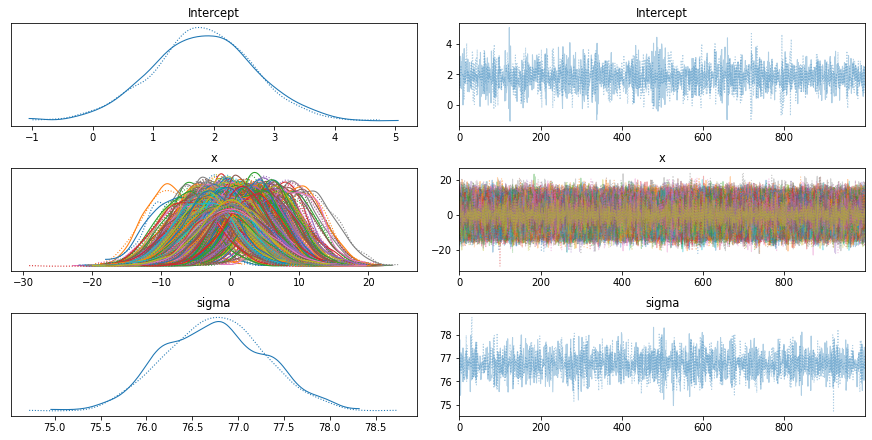

In [21]:
with model:
    az.plot_trace(trace)

## Next: Compare these results with ridge regression and standard linear regression

#### First - Linear Regression

Note - these results are very weird. Seems like the coefficients are either blowing up or going to zero. Perhaps ridge will be better.

In [152]:
# Linear Reg first:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(x, y)

In [153]:
reg.score(x,y)
reg.coef_

array([ 8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  8.20094185e+13,  8.20094185e+13,  8.20094185e+13,
        8.20094185e+13,  

## Ridge Regression

Below we fit a ridge regression model to the data and select a regularization parameter alpha using cross validation. Interesting note - the model always selects the largest value for alpha that we allow it to. Not sure why this is.

The top coefficients in this model are for the following players:

* Steph Curry
* Al Horford
* Jared Dudley (strange)
* Giannis
* Ricky Rubio
* James Harden
* Luka Doncic
* Eric Gordon
* Terrence Ross
* Trey Burke

These results seem less reasonable than the results from Bayesian Regression. 

**Note** - these results are quite similar to Bayesian Regression with prior means all equal to zero. We see Jared Dudley in the top ten for that as well, along with Steph Curry, Al Horford, Giannis, Ricky Rubio, Harden, Luka Doncic, and Eric Gordon.

In [135]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]).fit(x, y)
# cross validate for lambda

In [136]:
ridge_model.alpha_

100.0

In [146]:
player_index_map.loc[player_index_map.index == 184]

,player_id,index,player_name
184,203504.0,184,Trey Burke


In [137]:
coef_df = pd.DataFrame({'coefs': ridge_model.coef_, 'index': [i for i in range(len(ridge_model.coef_))]})
coef_df.sort_values(by = ['coefs']).tail(10)

,coefs,index
184,7.989637,184
71,8.368797,71
75,8.499369,75
95,8.838422,95
207,9.144946,207
170,9.148979,170
386,9.173845,386
275,9.312330,275
321,10.430350,321
317,10.894515,317
